# 05: Pronóstico de Producción para Ayatsil (v2)

* **Autor:** Emmanuel Eduardo
* **Fecha de Versión:** 2025-07-21
* **Versión:** 2.0 (Avanzada)
* **Proyecto:** Pronóstico de Producción - CNH

---

## Objetivo
Este notebook utiliza el modelo v2 entrenado para generar un pronóstico de producción a 12 meses para el campo Ayatsil. Visualiza y guarda la proyección futura.

## Entradas
* `gold/ayatsil_features_advanced_v2.parquet`
* `ml/modelos/ayatsil_xgb_advanced_v2.json`

## Salidas
* `ml/forecasts/forecast_ayatsil_12_meses_v2.csv`
* `ml/graficas/plot_forecast_ayatsil_12_meses_v2.png`


In [4]:
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [6]:
# --- 1. Configuración del Entorno y Rutas ---
ruta_base = os.path.abspath(os.path.join(os.getcwd(), "..",".."))
ruta_gold = os.path.join(ruta_base, "gold")
ruta_modelos = os.path.join(ruta_base, "ml", "modelos")
ruta_graficas = os.path.join(ruta_base, "ml", "graficas")
ruta_forecasts = os.path.join(ruta_base, "ml", "forecasts") # Nueva carpeta para guardar pronósticos
os.makedirs(ruta_forecasts, exist_ok=True)
os.makedirs(ruta_graficas, exist_ok=True)

In [8]:
# --- 2. Cargar el Modelo y los Datos Históricos ---
# Cargar el dataset con las características avanzadas
df_historico = pd.read_parquet(os.path.join(ruta_gold, "ayatsil_features_advanced_v2.parquet"))

# Cargar el modelo v2 ya entrenado
model_v2 = xgb.XGBRegressor()
model_v2.load_model(os.path.join(ruta_modelos, "ayatsil_xgb_advanced_v2.json"))
print("Modelo y datos históricos cargados.")

Modelo y datos históricos cargados.


In [12]:
# --- 3. Proceso de Pronóstico Iterativo a 12 Meses ---
print("Iniciando pronóstico a 12 meses...")
df_pronostico = df_historico.copy()
n_meses_a_predecir = 12

for i in range(n_meses_a_predecir):
    # Tomar la última fila disponible (que incluye las predicciones anteriores)
    ultima_fila = df_pronostico.iloc[-1:]

    # Crear las características para el siguiente mes
    fecha_siguiente = ultima_fila.index[0] + pd.DateOffset(months=1)
    
    ## Preparamos el registro con las características que el modelo espera
    features_siguientes = {
        # --- CORRECCIÓN: Se simplifica el acceso a los valores ---
        'produccion_mes_anterior': df_pronostico['petroleo_mbd'].iloc[-1],
        'produccion_promedio_3m': df_pronostico['petroleo_mbd'].iloc[-3:].mean(),
        'mes': fecha_siguiente.month,
        'trimestre': fecha_siguiente.quarter,
        'produccion_lag_6': df_pronostico['petroleo_mbd'].iloc[-6],
        'produccion_lag_12': df_pronostico['petroleo_mbd'].iloc[-12],
        'produccion_roll_mean_6': df_pronostico['petroleo_mbd'].iloc[-6:].mean(),
        'produccion_roll_std_6': df_pronostico['petroleo_mbd'].iloc[-6:].std(),
        'año': fecha_siguiente.year
        }
    
    df_features = pd.DataFrame([features_siguientes])
    
    # Realizar la predicción para el siguiente mes
    prediccion = model_v2.predict(df_features)[0]
    
    # Añadir la predicción al DataFrame para usarla en la siguiente iteración
    nueva_fila = features_siguientes
    nueva_fila['petroleo_mbd'] = prediccion
    df_pronostico.loc[fecha_siguiente] = nueva_fila

print("Pronóstico completado.")

Iniciando pronóstico a 12 meses...
Pronóstico completado.


In [14]:
# --- 4. Visualizar y Guardar Resultados ---
# Preparar datos para la gráfica
df_historico_plot = df_historico[['petroleo_mbd']].copy()
df_historico_plot['Tipo'] = 'Histórico'

df_pronostico_plot = df_pronostico.iloc[-n_meses_a_predecir:][['petroleo_mbd']].copy()
df_pronostico_plot['Tipo'] = 'Pronóstico'

df_plot = pd.concat([df_historico_plot, df_pronostico_plot])


Gráfica del pronóstico guardada en: C:\Users\elezr\Datalquemy\Proyectos\CNH\ml\graficas\plot_forecast_ayatsil_12_meses_v2.png


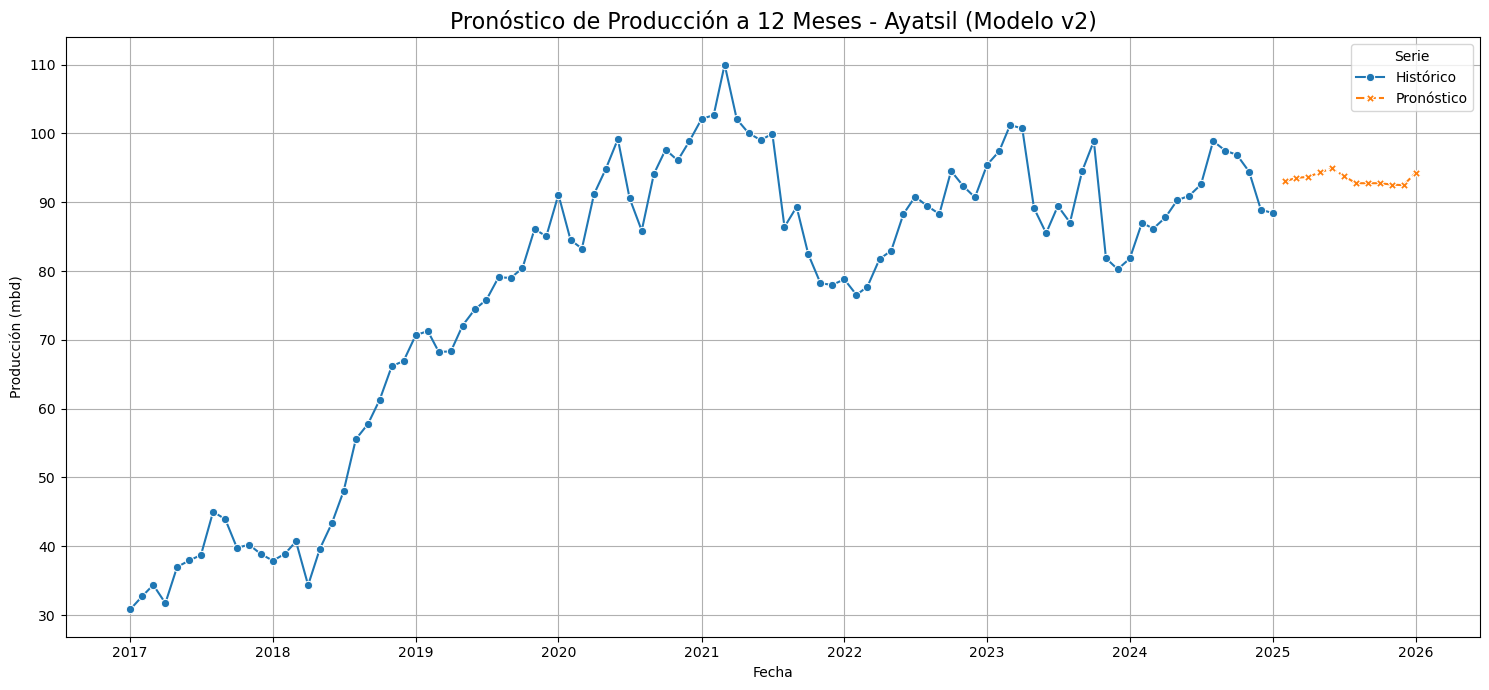

In [22]:
# Graficar
plt.figure(figsize=(15, 7))
sns.lineplot(data=df_plot, x=df_plot.index, y='petroleo_mbd', hue='Tipo', style='Tipo', markers=True)
plt.title('Pronóstico de Producción a 12 Meses - Ayatsil (Modelo v2)', fontsize=16)
plt.xlabel('Fecha')
plt.ylabel('Producción (mbd)')
plt.legend(title='Serie')
plt.grid(True)
plt.tight_layout()
# Guardar la gráfica
ruta_salida_grafico = os.path.join(ruta_graficas, "plot_forecast_ayatsil_12_meses_v2.png")
plt.savefig(ruta_salida_grafico, dpi=300)
print(f"\nGráfica del pronóstico guardada en: {ruta_salida_grafico}")
plt.show()

In [20]:
# Guardar los datos del pronóstico
datos_pronostico_final = df_pronostico.iloc[-n_meses_a_predecir:][['petroleo_mbd']]
ruta_salida_datos = os.path.join(ruta_forecasts, "forecast_ayatsil_12_meses_v2.csv")
datos_pronostico_final.to_csv(ruta_salida_datos)
print(f"Datos del pronóstico guardados en: {ruta_salida_datos}")

Datos del pronóstico guardados en: C:\Users\elezr\Datalquemy\Proyectos\CNH\ml\forecasts\forecast_ayatsil_12_meses_v2.csv
